# this notebook parse patch data
# TODO: meet with Venu to confirm the changes I made
# TODO: figure out the units in COSMED

In [1]:
import numpy as np
import argparse

import os
import math
from math import sin

import json

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary
torch.manual_seed(0)

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from plotting_tools import *
from setting import *
from models import *
from models_CNN import *
from evaluate import *

from stage3_preprocess import *
from training_util import *
from dataset_util import *
from dataIO import *

from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
print(torch.version.cuda)

11.3


In [3]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
                    default='101')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/stage3/', 
                          '--output_folder', '../../data/stage4/',
                          '--subject_id', 'sub106',
                          '--training_params_file', 'training_params_baseline.json',
                         ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage3/', output_folder='../../data/stage4/', subject_id='sub106', training_params_file='training_params_baseline.json')


In [4]:
inputdir = args.input_folder
outputdir = args.output_folder
subject_id = args.subject_id
training_params_file = args.training_params_file

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
outputdir_sub = outputdir+subject_id+'/'
if not os.path.exists(outputdir_sub):
    os.makedirs(outputdir_sub)
    

# get training params and dataloaders

In [5]:
torch.cuda.is_available()

True

In [6]:
with open(training_params_file) as json_file:
    training_params_list = json.load(json_file)

for training_params in [training_params_list[0]]:
    # include device in training_params
    device = torch.device('cuda:{}'.format(int(training_params['cuda_i'])) if torch.cuda.is_available() else 'cpu')
    training_params['device'] = device


    training_params['CV_config'] = {
        'subject_id': 113,
        'task_id': 1,
    }
    stage3_dict = data_loader('stage3_dict', inputdir).item()
    training_params['list_signal'] = stage3_dict['list_signal']
    training_params['list_feature'] = stage3_dict['list_feature']
    training_params['list_output'] = stage3_dict['list_output']
    training_params['list_meta'] = stage3_dict['list_meta']
    training_params['FS_RESAMPLE_DL'] = stage3_dict['FS_RESAMPLE_DL']
    training_params['subject_ids'] = stage3_dict['subject_ids']
    training_params['task_ids'] = stage3_dict['task_ids']
    
#     input_CV = '../../data/stage3/113/CV2/'
#     dataloaders, dataset_sizes = get_loaders(input_CV, training_params)
    dataloaders, dataset_sizes = get_loaders(inputdir, training_params)
    print('data dimensions are:', dataloaders['train'].dataset.data.shape)

    data_dimensions = dataloaders['train'].dataset.__getitem__(0)[0].size()
    training_params['data_dimensions'] = list(data_dimensions)
    
    sweep_name = training_params['sweep_name'] 
    

# training_params = training_params_list[0]

data dimensions are: (2236, 3, 6000)


# define multi-task loss

In [7]:
class MultiTaskLoss(nn.Module):
    def __init__(self, training_params):
        super(MultiTaskLoss, self).__init__()
        assert(set(training_params['tasks']) == set(training_params['criterions'].keys()))
        assert(set(training_params['tasks']) == set(training_params['loss_weights'].keys()))
        self.tasks = training_params['tasks']
        self.criterions = training_params['criterions']
        self.loss_weights = training_params['loss_weights']
        self.device = training_params['device']

    
    def forward(self, output, label):
        label = {task: label[:, [training_params['tasks'].index(task)]] for task in self.tasks}
#         print(label.keys())
#         print(output.keys())

        losses = {task: self.criterions[task](output[task].squeeze(), label[task].to(device=device, dtype=torch.float).squeeze()) for task in self.tasks}
#         print(losses)
        losses['total'] = torch.sum(torch.stack([self.loss_weights[task] * losses[task] for task in self.tasks]))
#         print(out)
        return losses
    
    
training_params['tasks'] = training_params['output_names']

training_params['criterions'] = {}
training_params['loss_weights'] = {}

for task in training_params['tasks']:
    training_params['criterions'][task] =  torch.nn.MSELoss()
    training_params['loss_weights'][task] =  0.5

criterion = MultiTaskLoss(training_params)

# some random param
## kernel_size = 5 ~ 16*100/300 (16 for 300 Hz sampling rate, 5 for 100 sampling rate)


In [8]:
training_params

{'model_name': 'cnn',
 'sweep_name': 'baseline',
 'kernel_size': [5],
 'channel_n': 16,
 'num_epochs': 30,
 'batch_size': 64,
 'learning_rate': 0.001,
 'cuda_i': 0,
 'use_sc': True,
 'wandb': True,
 'input_names': ['ECG', 'accelZ', 'ppg_r_1'],
 'feature_names': ['HR_patch', 'weight'],
 'output_names': ['EE_cosmed'],
 'meta_names': ['subject_id', 'task'],
 'device': device(type='cuda', index=0),
 'CV_config': {'subject_id': 113, 'task_id': 1},
 'list_signal': ['ECG', 'accelZ', 'ppg_r_1'],
 'list_feature': ['VE_cosmed', 'HR_patch', 'weight'],
 'list_output': ['RR_cosmed',
  'VT_cosmed',
  'EE_cosmed',
  'SPO2_cosmed',
  'HR_cosmed',
  'VO2_cosmed',
  'resp_cosmed'],
 'list_meta': ['subject_id', 'task'],
 'FS_RESAMPLE_DL': 100,
 'subject_ids': array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114,
        115, 116, 117, 118, 119, 120]),
 'task_ids': array([0, 1, 2, 3, 4, 5]),
 'data_dimensions': [3, 6000],
 'tasks': ['EE_cosmed'],
 'criterions': {'EE_cosmed': MSELoss()},


In [9]:
# training_params['downsample_gap']

# # n_block = training_params['n_block_macro'][0] * training_params['downsample_gap'][0]
# # downsample_gap = training_params['downsample_gap'][0]
# # base_filters = training_params['base_filters'][0]
# # use_sc =  training_params['use_sc']
# # increasefilter_gap = downsample_gap * 2
# # kernel_size = training_params['kernel_size']
# # groups = training_params['base_filters'][0]

In [10]:
if training_params['model_name'] == 'resnet':
    training_params['stride'] = [2]
    training_params['n_classes'] = [1]
#     training_params['groups'] = [32]
    training_params['groups'] = [4]
    training_params['downsample_gap'] = [3]
    training_params['n_block_macro'] = [4]
    training_params['n_block'] = [training_params['n_block_macro'][0] * training_params['downsample_gap'][0]]
    training_params['base_filters'] = [8]
    training_params['in_channels'] = training_params['data_dimensions'][0]
    training_params['increasefilter_gap'] = [training_params['downsample_gap'][0] * 2]
    

In [11]:
# # kernel_size = 10 # ~ 16*100/300 (16 for 300 Hz sampling rate, 5 for 100 sampling rate)

# training_params['stride'] = 2
# # stride = 2
# # increasefilter_gap = 12
# # base_filters = 32
# training_params['n_classes'] = 1
# # n_classes = 1 # regression
# training_params['groups'] = 32
# # groups = 32


In [12]:
training_params['data_dimensions']

[3, 6000]

In [13]:
# if training_params['model_name']=='resnet':
#     #     model = model_def(input_size=1,num_classes=2).apply(reset_weights)
#     n_block = training_params['n_block_macro'][0] * training_params['downsample_gap'][0]
#     downsample_gap = training_params['downsample_gap'][0]
#     base_filters = training_params['base_filters'][0]
#     use_sc =  training_params['use_sc']
#     increasefilter_gap = downsample_gap * 2
#     in_channels = training_params['data_dimensions'][0]


#     groups = training_params['base_filters'][0]

#     model = ResNet1D(
#         in_channels=in_channels, 
#         base_filters=base_filters, # 64 for ResNet1D, 352 for ResNeXt1D
#         kernel_size=kernel_size, 
#         stride=stride, 
#         groups=groups, 
#         n_block=n_block, 
#         n_classes=n_classes, 
#         downsample_gap=downsample_gap, 
#         increasefilter_gap=increasefilter_gap, 
#         use_do=True,
#         use_sc=use_sc
#     )
# elif training_params['model_name']=='cnn':
    
#     print('using model ', training_params['model_name'])
#     model = cnnnet(training_params=training_params)
#     summary(model, input_size=tuple(training_params['data_dimensions']), batch_size=16, device='cpu')
#     del model

In [14]:
# import torch
# import torch.nn as nn
# from torchsummary import summary

# class SimpleConv(nn.Module):
#     def __init__(self):
#         super(SimpleConv, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#         )

#     def forward(self, x, y):
#         x1 = self.features(x)
#         x2 = self.features(y)
#         return x1, x2
    
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleConv().to(device)

# summary(model, [(1, 16, 16), (1, 28, 28)])

# # [tuple(training_params['data_dimensions']), tuple([2])]

# test the model

# TODO: need to fix summary()

In [15]:
training_params

{'model_name': 'cnn',
 'sweep_name': 'baseline',
 'kernel_size': [5],
 'channel_n': 16,
 'num_epochs': 30,
 'batch_size': 64,
 'learning_rate': 0.001,
 'cuda_i': 0,
 'use_sc': True,
 'wandb': True,
 'input_names': ['ECG', 'accelZ', 'ppg_r_1'],
 'feature_names': ['HR_patch', 'weight'],
 'output_names': ['EE_cosmed'],
 'meta_names': ['subject_id', 'task'],
 'device': device(type='cuda', index=0),
 'CV_config': {'subject_id': 113, 'task_id': 1},
 'list_signal': ['ECG', 'accelZ', 'ppg_r_1'],
 'list_feature': ['VE_cosmed', 'HR_patch', 'weight'],
 'list_output': ['RR_cosmed',
  'VT_cosmed',
  'EE_cosmed',
  'SPO2_cosmed',
  'HR_cosmed',
  'VO2_cosmed',
  'resp_cosmed'],
 'list_meta': ['subject_id', 'task'],
 'FS_RESAMPLE_DL': 100,
 'subject_ids': array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114,
        115, 116, 117, 118, 119, 120]),
 'task_ids': array([0, 1, 2, 3, 4, 5]),
 'data_dimensions': [3, 6000],
 'tasks': ['EE_cosmed'],
 'criterions': {'EE_cosmed': MSELoss()},


In [16]:
def test_model(training_params):
    
    if training_params['model_name']=='resnet':
        print('using model ', training_params['model_name'])
    #     device = training_params['device']
        device = torch.device('cuda:{}'.format(int(training_params['cuda_i'])) if torch.cuda.is_available() else 'cpu')

    #     model = model_def(input_size=1,num_classes=2).apply(reset_weights)

#         n_block = training_params['n_block_macro'][0] * training_params['downsample_gap'][0]
#         downsample_gap = training_params['downsample_gap'][0]
#         base_filters = training_params['base_filters'][0]
#         use_sc =  training_params['use_sc']
#         increasefilter_gap = downsample_gap * 2
#         kernel_size = training_params['kernel_size']
#         groups = training_params['base_filters'][0]

#         model = ResNet1D(
#             in_channels=training_params['data_dimensions'][0], 
#             base_filters=base_filters, # 64 for ResNet1D, 352 for ResNeXt1D
#             kernel_size=kernel_size, 
#             stride=stride, 
#             groups=groups, 
#             n_block=n_block, 
#             n_classes=n_classes, 
#             downsample_gap=downsample_gap, 
#             increasefilter_gap=increasefilter_gap, 
#             use_do=True,
#             use_sc=use_sc
#         )
        model = resnet_multiverse(
            training_params=training_params
        )

    #     model= model_def(in_ch=training_params['data_dimensions'][0], out_ch=2, n1=training_params['N_channels'])
#         summary(model, input_size=tuple(training_params['data_dimensions']), batch_size=16, device='cpu')
        summary(model, input_size=[tuple(training_params['data_dimensions']), tuple([2,1])], device='cpu')
        del model
    

    elif training_params['model_name']=='cnn':

        print('using model ', training_params['model_name'])

        model = cnnnet(training_params=training_params)
#         print(model)
# #         summary(model, input_size=tuple(training_params['data_dimensions']), batch_size=16, device='cpu')
# #         summary(model, input_size=[tuple(training_params['data_dimensions']), tuple([2])], batch_size=16, device='cpu')
# #         summary(model, input_size=[tuple(training_params['data_dimensions']), tuple([2])], device='cpu')
        summary(model, input_size=[tuple(training_params['data_dimensions']), (model.N_features,1)], device='cpu')



debug_model = True
if debug_model==True:
#     test_model(ResNet1D, training_params)
    test_model(training_params)

using model  cnn
feature_out_dim: 83536
feature_out_dim: 83536
feature_out_dim: 83536
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 6000]              96
       BatchNorm1d-2             [-1, 16, 6000]              32
              ReLU-3             [-1, 16, 6000]               0
            Conv1d-4             [-1, 16, 5993]           3,088
       BatchNorm1d-5             [-1, 16, 5993]              32
              ReLU-6             [-1, 16, 5993]               0
            Conv1d-7             [-1, 16, 5967]           7,952
       BatchNorm1d-8             [-1, 16, 5967]              32
              ReLU-9             [-1, 16, 5967]               0
           Conv1d-10             [-1, 16, 5894]          19,984
      BatchNorm1d-11             [-1, 16, 5894]              32
             ReLU-12             [-1, 16, 5894]               0
           Conv1d

# define training, validating, and evaluating funcitons 

In [17]:
trainer = train_resnet
evaler = eval_resnet
preder = pred_resnet

# training and eval block
# TODO: modularize it

# init the model

In [18]:
# if training_params['model_name']=='resnet':
#     print('using model ', training_params['model_name'])
# #     device = training_params['device']
#     device = torch.device('cuda:{}'.format(int(training_params['cuda_i'])) if torch.cuda.is_available() else 'cpu')

# #     model = model_def(input_size=1,num_classes=2).apply(reset_weights)

#     n_block = training_params['n_block_macro'][0] * training_params['downsample_gap'][0]
#     downsample_gap = training_params['downsample_gap'][0]
#     base_filters = training_params['base_filters'][0]
#     use_sc =  training_params['use_sc']
#     increasefilter_gap = downsample_gap * 2
#     kernel_size = training_params['kernel_size']

#     groups = training_params['base_filters'][0]

#     model = ResNet1D(
#         in_channels=training_params['data_dimensions'][0], 
#         base_filters=base_filters, # 64 for ResNet1D, 352 for ResNeXt1D
#         kernel_size=kernel_size, 
#         stride=stride, 
#         groups=groups, 
#         n_block=n_block, 
#         n_classes=n_classes, 
#         downsample_gap=downsample_gap, 
#         increasefilter_gap=increasefilter_gap, 
#         use_do=True,
#         use_sc=use_sc
#     )

# #     model= model_def(in_ch=training_params['data_dimensions'][0], out_ch=2, n1=training_params['N_channels'])
# #     summary(model, input_size=tuple(training_params['data_dimensions']), batch_size=16, device='cpu')
# #     del model

if training_params['model_name']=='resnet':
    print('using model ', training_params['model_name'])
    model = resnet_multiverse(
        training_params=training_params
    )
    
elif training_params['model_name']=='cnn':

    print('using model ', training_params['model_name'])
    model = cnnnet(training_params=training_params)
#     summary(model, input_size=tuple(training_params['data_dimensions']), batch_size=16, device='cpu')


using model  cnn
feature_out_dim: 83536
feature_out_dim: 83536
feature_out_dim: 83536


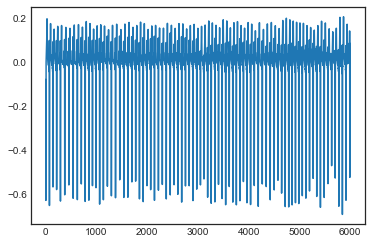

In [19]:
k = 100

plt.plot(dataloaders['train'].dataset.data[k,0,:])

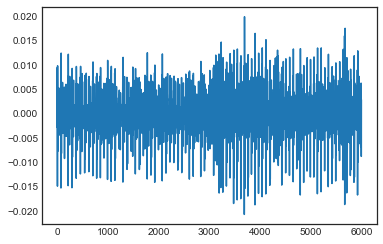

In [20]:
plt.plot(dataloaders['train'].dataset.data[k,1,:])

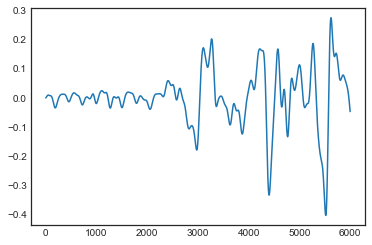

In [21]:
plt.plot(dataloaders['train'].dataset.data[k,2,:])

In [22]:
dataloaders['train'].dataset.meta

array([[101,   0],
       [101,   0],
       [101,   0],
       ...,
       [120,   5],
       [120,   5],
       [120,   5]])

In [23]:
dataloaders['train'].dataset.feature[0,:]

array([-5.11723763e-03,  9.00000000e+01])

In [24]:
dataloaders['train'].dataset.label

array([[2.41541989],
       [2.36579274],
       [2.30260067],
       ...,
       [1.90960189],
       [1.86916633],
       [1.83768278]])

In [25]:

# input_CV = '../../data/stage3/113/CV2/'
# dataloaders, dataset_sizes = get_loaders(input_CV, training_params)

In [26]:
training_params

{'model_name': 'cnn',
 'sweep_name': 'baseline',
 'kernel_size': [5],
 'channel_n': 16,
 'num_epochs': 30,
 'batch_size': 64,
 'learning_rate': 0.001,
 'cuda_i': 0,
 'use_sc': True,
 'wandb': True,
 'input_names': ['ECG', 'accelZ', 'ppg_r_1'],
 'feature_names': ['HR_patch', 'weight'],
 'output_names': ['EE_cosmed'],
 'meta_names': ['subject_id', 'task'],
 'device': device(type='cuda', index=0),
 'CV_config': {'subject_id': 113, 'task_id': 1},
 'list_signal': ['ECG', 'accelZ', 'ppg_r_1'],
 'list_feature': ['VE_cosmed', 'HR_patch', 'weight'],
 'list_output': ['RR_cosmed',
  'VT_cosmed',
  'EE_cosmed',
  'SPO2_cosmed',
  'HR_cosmed',
  'VO2_cosmed',
  'resp_cosmed'],
 'list_meta': ['subject_id', 'task'],
 'FS_RESAMPLE_DL': 100,
 'subject_ids': array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114,
        115, 116, 117, 118, 119, 120]),
 'task_ids': array([0, 1, 2, 3, 4, 5]),
 'data_dimensions': [3, 6000],
 'tasks': ['EE_cosmed'],
 'criterions': {'EE_cosmed': MSELoss()},


In [27]:
def train_model(model, training_params, trainer, evaler, preder):

    #     print('train_model.....')


    inputdir = training_params['inputdir']
    
    dataloaders, dataset_sizes = get_loaders(inputdir, training_params)


    total_loss_train = np.zeros(training_params['num_epochs'])
    total_loss_val = np.zeros(training_params['num_epochs'])



#     print(training_params)
    print('\t start training.....')

    for epoch in range(training_params['num_epochs']):
        if epoch%10==1:
            print(epoch)
        training_params['epoch'] = epoch

        ##### model training mode ####
        performance_dict_train = trainer(model, dataloaders['train'], training_params)
    #         performance_dict_train = train_resnet(model, dataloaders['train'], optimizer, criterion, epoch, training_params)
        total_loss_train[epoch] = performance_dict_train['total_loss']

        performance_dict_val = evaler(model, dataloaders['val'], training_params)
    #         performance_dict_val = eval_resnet(model, dataloaders['val'], optimizer, criterion, epoch, training_params)
        total_loss_val[epoch] = performance_dict_val['total_loss']


    print('\t done with training.....')

    performance_dict_train = preder(model, dataloaders['train'], training_params)
    performance_dict_val = preder(model, dataloaders['val'], training_params)

    
    CV_dict = {
        'performance_dict_train': performance_dict_train,
        'total_loss_train': total_loss_train,
        'performance_dict_val': performance_dict_val,
        'total_loss_val': total_loss_val,
        'model': model,
        'subject_id_val': training_params['CV_config']['subject_id'], 
    }
    

#     for task in training_params['tasks']:
#         print('evaluating task:', task)
#         MAE, std_AE = get_MAE(performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task])
#         print('\ttrainin: {:.2f}, {:.2f}'.format(MAE, std_AE))

#         MAE, std_AE = get_MAE(performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task])
#         print('\tval: {:.2f}, {:.2f}'.format(MAE, std_AE))

#         CV_dict[task+'_RMSE']
    
    return CV_dict






In [28]:

def get_df_performance(df_performance, label, label_est, task, subject_id):
    rmse = np.sqrt(mean_squared_error(label, label_est))

    mae, _ = get_MAE(label, label_est)
    mape, _ = get_MAPE(label, label_est)

    Rsquared = get_CoeffDeterm(label=label, predictions=label_est)

    df_performance.append(pd.DataFrame({
        'CV': [subject_id],
        'task': [task],
        'Rsquared': [Rsquared],
        'rmse': [rmse],
        'mae': [mae],
        'mape': [mape],
    }))
    
    return df_performance

In [29]:
# CV_dict.keys()
# subject_id = subject_id_val


In [30]:
def plot_losses(CV_dict, show_plot=False, outputdir=None):
    
    total_loss_train = CV_dict['total_loss_train']
    total_loss_val = CV_dict['total_loss_val']
    
    fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=80)
    fontsize = 15

    ax.plot(total_loss_train, 'r', label='train')
    ax.plot(total_loss_val,'b', label='val')
    ax.legend(loc='upper right', frameon=True, fontsize=fontsize*0.8)

    ax.set_xlabel('epoch', fontsize=fontsize)
    ax.set_ylabel('MSE', fontsize=fontsize)

    fig.tight_layout()

    subject_id = CV_dict['subject_id_val']
    #     fig_name = '{}_signl_{}'.format(title_str,subject_id)
    fig_name = 'loss_CV{}'.format(subject_id)
#     show_plot=True
    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')



In [31]:

def get_df_performance2(label, label_est, subject_id, task):
    
#     df_performance = pd.DataFrame()

    
#     for subject_id in df_outputlabel['subject_id'].unique():
#         df_sub = df_outputlabel[df_outputlabel['subject_id']==subject_id]
#         task = df_sub['task'][0]
        
        
#         label = df_sub['label']
#         label_est = df_sub['label_est']


    rmse = np.sqrt(mean_squared_error(label, label_est))

    mae, _ = get_MAE(label, label_est)
    mape, _ = get_MAPE(label, label_est)

    Rsquared = get_CoeffDeterm(label=label, predictions=label_est)

    df_performance = pd.DataFrame({
        'CV': [subject_id],
        'task': [task],
        'Rsquared': [Rsquared],
        'rmse': [rmse],
        'mae': [mae],
        'mape': [mape],
    })

    return df_performance

In [ ]:
# df_performance_train = []
# df_performance_val = []
df_performance_train = pd.DataFrame()
df_performance_val = pd.DataFrame()

# df_outputlabel_train = []
# df_outputlabel_val = []
df_outputlabel_train = pd.DataFrame()
df_outputlabel_val = pd.DataFrame()


for subject_id in training_params['subject_ids']:
# for subject_id in training_params['subject_ids'][::-1]:
#     if subject_id != 113:
#         continue

    training_params['CV_config']['subject_id'] = subject_id


    device = torch.device('cuda:{}'.format(int(training_params['cuda_i'])) if torch.cuda.is_available() else 'cpu')
    print('using device', device)

    model = model.to(device).float()

    optimizer = torch.optim.Adam(model.parameters(), lr=training_params['learning_rate'], weight_decay=0.01)

    training_params['criterion'] = criterion
    training_params['optimizer'] = optimizer
    training_params['inputdir'] = inputdir

    CV_dict = train_model(model, training_params, trainer, evaler, preder)
    plot_losses(CV_dict, outputdir=outputdir, show_plot=False)

    for task in training_params['tasks']:
        label_est_val = CV_dict['performance_dict_val']['out_dict'][task]
        label_val = CV_dict['performance_dict_val']['label_dict'][task]

        label_est_train = CV_dict['performance_dict_train']['out_dict'][task]
        label_train = CV_dict['performance_dict_train']['label_dict'][task]

#         df_performance_train = get_df_performance(df_performance_train, label_train, label_est_train, task, subject_id)
#         df_performance_val = get_df_performance(df_performance_val, label_val, label_est_val, task, subject_id)


        
        df_performance_train = df_performance_train.append( get_df_performance2(label_train, label_est_train, subject_id, task), ignore_index=True )
        df_performance_train.to_csv(outputdir+'df_performance_train.csv', index=False)

        df_performance_val = df_performance_val.append( get_df_performance2(label_val, label_est_val, subject_id, task), ignore_index=True )
        df_performance_val.to_csv(outputdir+'df_performance_val.csv', index=False)

#         df_outputlabel_val.append(
#             pd.DataFrame( {
#             'label_est': label_est_val,
#             'label': label_val,
#             'CV': [subject_id]*label_val.shape[0],
#             'task': [task]*label_val.shape[0]
#             }) )
#         df_outputlabel_train.append(
#             pd.DataFrame( {
#             'label_est': label_est_train,
#             'label': label_train,
#             'CV': [subject_id]*label_train.shape[0],
#             'task': [task]*label_train.shape[0]
#             }) )
        
        
        df_outputlabel_val = df_outputlabel_val.append(
            pd.DataFrame( {
            'label_est': label_est_val,
            'label': label_val,
            'CV': [subject_id]*label_val.shape[0],
            'task': [task]*label_val.shape[0]
            }), ignore_index=True )
        
        df_outputlabel_val.to_csv(outputdir+'df_outputlabel_val.csv', index=False)

        df_outputlabel_train = df_outputlabel_train.append(
            pd.DataFrame( {
            'label_est': label_est_train,
            'label': label_train,
            'CV': [subject_id]*label_train.shape[0],
            'task': [task]*label_train.shape[0]
            }), ignore_index=True )
        
        df_outputlabel_train.to_csv(outputdir+'df_outputlabel_train.csv', index=False)



using device cuda:0
	 start training.....
1
11
21
	 done with training.....
using device cuda:0
	 start training.....
1


In [ ]:
# df_outputlabel_val =  pd.DataFrame()
# df_outputlabel_val.append(
#     pd.DataFrame( {
#     'label_est': label_est_val,
#     'label': label_val,
#     'CV': [subject_id]*label_val.shape[0],
#     'task': [task]*label_val.shape[0]
#     }), ignore_index=True )
# df_outputlabel_val.append(
#     pd.DataFrame( {
#     'label_est': label_est_val,
#     'label': label_val,
#     'CV': [subject_id]*label_val.shape[0],
#     'task': [task]*label_val.shape[0]
#     }), ignore_index=True )
# df_outputlabel_val.append(
#     pd.DataFrame( {
#     'label_est': label_est_val,
#     'label': label_val,
#     'CV': [subject_id]*label_val.shape[0],
#     'task': [task]*label_val.shape[0]
#     }), ignore_index=True )

# # df_outputlabel_val.append(
# # pd.DataFrame({
# #             'label_est': label_est_val,
# #             'label': label_val,
# #             'CV': [subject_id]*label_val.shape[0],
# #             'task': [task]*label_val.shape[0]
# #             })
# #            , ignore_index=True)

In [ ]:
# df_performance_train = pd.concat(df_performance_train)
# df_performance_val = pd.concat(df_performance_val)

# # df_outputlabel_train = pd.concat(df_outputlabel_train)
# # df_outputlabel_val = pd.concat(df_outputlabel_val)

In [ ]:
df_performance_val['rmse'].mean(), df_performance_val['mae'].mean(), df_performance_val['mape'].mean()

In [ ]:
    
# def plot_regression_partial(ax, subjects_performance_dict, subject_id_plt, training_params,outputdir=None, show_plot=False, log_wandb=False):

#     agg_performance_dict = aggregate_performance_dict(subjects_performance_dict)

#     props = dict(boxstyle='round,pad=0.7', facecolor='white', edgecolor='black', alpha=0.7)
#     fontsize = 16

#     subject_ids = list(subjects_performance_dict.keys())
#     N_beats_val = 0


#     for subject_id in subject_ids:
#         if int(subject_id)//100 == 0:
#             marker = marker_dict['x']
#         elif int(subject_id)//100 == 1:
#             marker = marker_dict['circle']

#         performance_dict = subjects_performance_dict[subject_id]

#         SpO2_val = performance_dict['SpO2_val']
#         SpO2_est_val = performance_dict['SpO2_est_val']


#         color = color_dict[color_names[int(subject_id)%100]]

#         if subject_id == subject_id_plt:
#             alpha=0.6
#             ax.set_title('{}'.format(subject_id), fontsize=fontsize+5)
#             rmse_val = performance_dict['rmse_val']
#         else:
#             alpha=0.03

#         ax.scatter(SpO2_val, SpO2_est_val, alpha=alpha, color=color, marker=marker)

#         N_beats_val += SpO2_val.shape[0]
        
    
#     performance_dict = subjects_performance_dict[subject_id_plt]
# #     print(training_params['use_calibration'], subjects_performance_dict.keys())
#     if training_params['use_calibration']:
#         if 'SpO2_cal_range' in performance_dict:
#             SpO2_cal_range = performance_dict['SpO2_cal_range']
#             subject_id_plt = str(subject_id_plt) + '\n[' + r'$SpO_{2}$' + ' range: {:.1f}-{:.1f}%]'.format(SpO2_cal_range[0], SpO2_cal_range[1])
#     ax_conditioning2(ax, subject_id_plt, fontsize, props, 'RMSE={:.2f}%'.format(rmse_val))
    
    

In [ ]:
        
# def ax_conditioning(ax, title_str, fontsize, props, textstr):
#     ax.set_title(title_str, fontsize=fontsize+5)

#     ax.set_ylabel(r'$SpO_{2}$'+' estimated (%)', fontsize=fontsize)
#     ax.set_xlabel(r'$SpO_{2}$'+' label (%)', fontsize=fontsize)

#     major_ticks = np.arange(label_range_dict['SpO2'][0],label_range_dict['SpO2'][1]+1,5)
#     minor_ticks = np.arange(label_range_dict['SpO2'][0],label_range_dict['SpO2'][1]+1)

#     ax.set_xticks(major_ticks)
#     ax.set_xticks(minor_ticks, minor=True)
#     ax.set_yticks(major_ticks)
#     ax.set_yticks(minor_ticks, minor=True)
#     # Or if you want different settings for the grids:
#     ax.grid(which='minor', alpha=0.3)
#     ax.grid(which='major', alpha=0.8)


#     ax.plot( label_range_dict['SpO2'],label_range_dict['SpO2'] , color='gray', alpha=0.5)
# #     ax.legend(loc='upper left', frameon=True, fontsize=fontsize-7)


#     # place a text box in bottom right in axes coords
# #     ax.text(0.5, 0.08, textstr, transform=ax.transAxes, fontsize=fontsize-5,
# #     verticalalignment='bottom', horizontalalignment='left', bbox=props)
#     ax.set_ylim(label_range_dict['SpO2'])
#     ax.set_xlim(label_range_dict['SpO2'])
    
    

In [ ]:
# sns.scatterplot(data=df_outputlabel_train, x='label', y='label_est', hue='CV', palette=subject_palette)

In [ ]:
def ax_no_top_right(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)



In [ ]:
df_performance_val['rmse'].mean(), df_performance_val['mae'].mean(), df_performance_val['mape'].mean()

In [ ]:
def plot_regression(df_outputlabel_val, df_performance_val, task, show_plot=False, outputdir=None):

    fig, ax = plt.subplots(1,1, figsize=(5, 5), dpi=150, facecolor='white')
    props = dict(boxstyle='round,pad=0.7', facecolor='white', edgecolor='black', alpha=0.7)
    fontsize = 16
    alpha=0.1

    task_name = task.split('_')[0]
    sc = sns.scatterplot(data=df_outputlabel_val, x='label', y='label_est', hue='CV',  ec="None", palette=subject_palette, alpha=alpha, s=50, marker='o', ax=ax)
    # sc.set_edgecolor("none")

    # ax.scatter(bbb['label_est'], bbb['label'], alpha=0.1)

    label_range = [my_floor(df_outputlabel_val[['label', 'label_est']].min().min()), my_ceil(df_outputlabel_val[['label', 'label_est']].max().max())]

    N_sub = len(df_outputlabel_val['CV'].unique())
    N_samples = df_outputlabel_val.shape[0]
    t_dur = N_samples*3/60
    PCC = get_PCC(df_outputlabel_val['label'], df_outputlabel_val['label_est'])
    Rsquared = get_CoeffDeterm(df_outputlabel_val['label'], df_outputlabel_val['label_est'])



    title_str = '{} range: {:.1f}-{:.1f} {}'.format(task.split('_')[0], label_range[0], label_range[1], unit_dict[task_name])
    textstr = 'RMSE={:.2f} {}\nMAE={:.2f} {}\nMAPE={:.2f} {}\nPCC={:.2f}\nR2={:.2f}\nN_sub={}\nN_samples={}\nduration={:.2f} min'.format(
        df_performance_val['rmse'].mean(), unit_dict[task_name], df_performance_val['mae'].mean(), unit_dict[task_name], df_performance_val['mape'].mean()*100, '%',
        PCC, Rsquared,
        N_sub, N_samples, t_dur)

    # ax_conditioning(ax, plt_title, fontsize, props, 'RMSE={:.2f}%'.format(df_performance_val['rmse'].mean()))

    ax.set_title(title_str, fontsize=fontsize+5)

    ax.set_ylabel('{} estimated ({})'.format(task.split('_')[0], unit_dict[task_name]), fontsize=fontsize)
    ax.set_xlabel('{} label ({})'.format(task.split('_')[0], unit_dict[task_name]), fontsize=fontsize)


    # major_ticks = np.arange( my_floor(label_range[0]), my_ceil(label_range[1]),5)
    # minor_ticks = np.arange( my_floor(label_range[0]), my_ceil(label_range[1]))
    major_ticks = np.arange(label_range[0],label_range[1]+1,5)
    minor_ticks = np.arange(label_range[0],label_range[1]+1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    # Or if you want different settings for the grids:
    ax.grid(which='minor', alpha=0.3)
    ax.grid(which='major', alpha=0.8)


    ax.plot( label_range,label_range , color='gray', alpha=0.5, linestyle='--')
    ax.legend(frameon=True, fontsize=fontsize-7, bbox_to_anchor=(1.01, 1))


    # # place a text box in bottom right in axes coords
    ax.text(0.05, 0.65, textstr, transform=ax.transAxes, fontsize=fontsize-7,
            verticalalignment='bottom', horizontalalignment='left', bbox=props)

    ax.set_ylim(label_range)
    ax.set_xlim(label_range)

    ax_no_top_right(ax)

    fig.tight_layout()
    fig_name = 'regression_analysis'

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')


In [ ]:
plot_regression(df_outputlabel_val, df_performance_val, task, show_plot=True, outputdir=outputdir)


In [ ]:
import matplotlib.ticker as plticker

# def BA_plotter(ax, df, mode):
def plot_BA(df_outputlabel_val, task, show_plot=False, outputdir=None):
    fig, ax = plt.subplots(1,1, figsize=(6, 5), dpi=150, facecolor='white')
    task_name = task.split('_')[0]

    label = df_outputlabel_val['label']
    label_est =  df_outputlabel_val['label_est']

    fontsize = 16
    alpha=0.1
        # plot Bland-Altman plot

    data1     = label
    data2     = label_est
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    diff_max = np.abs(diff).max()
    #     # plot running average of the error along x-axis (TBD)
    #     plot_smooth_err(ax, mean, diff)


    ax.axhline(md,           color='gray', linestyle='--')
    ax.axhline(md + 1.96*sd, color='gray', linestyle='--')
    ax.axhline(md - 1.96*sd, color='gray', linestyle='--')


    task_name = task.split('_')[0]

    for subject_id in df_outputlabel_val['CV'].unique():

        df_sub = df_outputlabel_val[df_outputlabel_val['CV']==subject_id]
        label = df_sub['label']
        label_est =  df_sub['label_est']

        mean = np.mean([label_est, label], axis=0)
        diff = label_est - label

        ax.scatter(x=mean,y=diff, alpha=alpha, color=subject_palette[subject_id])


    ax.set_ylim(-diff_max,diff_max)


    ax.set_ylabel('Estimated {} - Reference {}\n[{}]'.format(task_name, task_name, unit_dict[task_name]), fontsize=fontsize)
    ax.set_xlabel('Average of Estimated and Reference {} [{}]'.format(task_name, unit_dict[task_name]), fontsize=fontsize)

    #     ax.xaxis.grid(True, which='major')
    #     ax.xaxis.grid(True, which='minor', alpha=0.4)
    #     ax.yaxis.grid(True, which='major')
    #     ax.yaxis.grid(True, which='minor', alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)


    #     ax.figure.set_size_inches(14, 7)
    # ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax_no_top_right(ax)


    fig.tight_layout()

    fig_name = 'BA_analysis'

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')


In [ ]:
plot_BA(df_outputlabel_val, task, show_plot=True, outputdir=outputdir)


In [ ]:
# plt.plot(df_outputlabel_val['label_est'])
# plt.plot(df_outputlabel_val['label'])

In [ ]:
sys.exit()

# 2/21 3:00pm

In [ ]:
df_performance_val['rmse'].mean(), df_performance_val['mae'].mean(), df_performance_val['mape'].mean()

In [ ]:

    
    
#     print('evaluating task:', task)
#     MAE, std_AE = get_MAE(performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task])
#     print('\ttrainin: {:.2f}, {:.2f}'.format(MAE, std_AE))

#     MAE, std_AE = get_MAE(performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task])
#     print('\tval: {:.2f}, {:.2f}'.format(MAE, std_AE))

#     CV_dict[task+'_RMSE']

In [ ]:


# rmse_train = np.sqrt(mean_squared_error(label_train, label_est_train))
# rmse_val = np.sqrt(mean_squared_error(label_val, label_est_val))

# mae_train, _ = get_MAE(label_train, label_est_train)
# mape_train, _ = get_MAPE(label_train, label_est_train)

# mae_val, _ = get_MAE(label_val, label_est_val)
# mape_val, _ = get_MAPE(label_val, label_est_val)

# Rsquared_train = get_CoeffDeterm(label=label_train, predictions=label_est_train)
# Rsquared_val = get_CoeffDeterm(label=label_val, predictions=label_est_val)

# df_performance_val.append(pd.DataFrame({
#     'CV': subject_id,
#     'Rsquared_val': Rsquared_val,
#     'rmse_val': rmse_val,
#     'mae_val': mae_val,
#     'mape_val': mape_val,
# }))

# df_performance_train.append(pd.DataFrame({
#     'CV': subject_id,
#     'Rsquared_val': Rsquared_train,
#     'rmse_val': rmse_train,
#     'mae_val': mae_train,
#     'mape_val': mape_train,
# }))

In [ ]:
# # label_val = CV_dict['performance_dict_val']['label_dict'][task]
# df_performance = []
# label_est = CV_dict['performance_dict_train']['out_dict'][task]
# label = CV_dict['performance_dict_train']['label_dict'][task]



# rmse = np.sqrt(mean_squared_error(label, label_est))

# mae, _ = get_MAE(label, label_est)
# mape, _ = get_MAPE(label, label_est)

# Rsquared = get_CoeffDeterm(label=label, predictions=label_est)

# df_performance.append(pd.DataFrame({
#     'CV': [subject_id],
#     'Rsquared': [Rsquared],
#     'rmse': [rmse],
#     'mae': [mae],
#     'mape': [mape],
# }))

In [ ]:
# rmse, mae, mape, Rsquared

In [ ]:
performance_dict_train = preder(model, dataloaders['train'], training_params)
performance_dict_val = preder(model, dataloaders['val'], training_params)

for task in training_params['tasks']:
    print('evaluating task:', task)
    MAE, std_AE = get_MAE(performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task])
    print('\ttrainin: {:.2f}, {:.2f}'.format(MAE, std_AE))

    MAE, std_AE = get_MAE(performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task])
    print('\tval: {:.2f}, {:.2f}'.format(MAE, std_AE))



# get faeture maps

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


data = torch.from_numpy(dataloaders['val'].dataset.data)
feature = torch.from_numpy(dataloaders['val'].dataset.feature)
data = data.to(device).float()
feature = feature.to(device).float()
# model = MyModel()
model.feature_extractor.layer1.register_forward_hook(get_activation('layer1'))
model.feature_extractor.layer2.register_forward_hook(get_activation('layer2'))
model.feature_extractor.layer3.register_forward_hook(get_activation('layer3'))
model.feature_extractor.layer4.register_forward_hook(get_activation('layer4'))
model.feature_extractor.layer5.register_forward_hook(get_activation('layer5'))
model.feature_extractor.layer6.register_forward_hook(get_activation('layer6'))
# model.feature_extractor.layer7.register_forward_hook(get_activation('layer7'))
# model.regressors.RR_cosmed.fc1.register_forward_hook(get_activation('RR_fc1'))
# x = torch.randn(1, 25)
output = model(data, feature)
print(activation['layer1'].size())
print(activation['layer2'].size())
print(activation['layer3'].size())
print(activation['layer4'].size())
print(activation['layer5'].size())
print(activation['layer6'].size())
# print(activation['layer7'].size())
# print(activation['RR_fc1'].size())

In [ ]:
data = data.cpu().detach().numpy()

data_layer1 = activation['layer1'].cpu().detach().numpy()
data_layer2 = activation['layer2'].cpu().detach().numpy()
data_layer3 = activation['layer3'].cpu().detach().numpy()
data_layer4 = activation['layer4'].cpu().detach().numpy()
data_layer5 = activation['layer5'].cpu().detach().numpy()
data_layer6 = activation['layer6'].cpu().detach().numpy()
# data_layer7 = activation['layer7'].cpu().detach().numpy()

In [ ]:
dataloaders['train'].dataset.label[0,:]

In [ ]:
dataloaders['train'].dataset.label.shape

In [ ]:

i = 10
# i = 20

data_layer = data_layer5

fig, axes = plt.subplots(data_layer.shape[1]+1,1, figsize=(20,data_layer.shape[1]), dpi=80, gridspec_kw = {'wspace':0, 'hspace':0})
fontsize = 15

FS_RESAMPLE_DL = training_params['FS_RESAMPLE_DL']

t_arr = np.arange(data.shape[-1])/FS_RESAMPLE_DL
# fig, ax = plt.subplots(1,1, figsize=(20,1), dpi=80, gridspec_kw = {'wspace':0, 'hspace':0})
ax = axes[0]
ax.plot(t_arr, data[i,0,:])
ax.set_xlim(t_arr.min(), t_arr.max()) # remove the weird white space at the beg and end of the plot
ax.set_ylabel('ECG [mV]', fontsize=fontsize,rotation = 0,  va='center', ha='center',  labelpad=100)

# RR = dataloaders['train'].dataset.label[i,:][1]
# ax.set_title('ECG and CNN intermediate output\nRR={:.3f}bpm ({:.3f} breaths)'.format(RR, RR/2), fontsize=fontsize*1.5)


t_arr = np.arange(data_layer.shape[-1])/FS_RESAMPLE_DL
for j, ax in enumerate(axes[1:]):

    if j<len(axes)-2:
        ax.set_xticklabels([])
        
        
    ax.plot(t_arr, data_layer[i, j, :].T, alpha=1)
#     ax.plot(t_arr, data_layer.mean(axis=1).T[:,j], alpha=1)
    
    ax.set_xlim(t_arr.min(), t_arr.max()) # remove the weird white space at the beg and end of the plot
    # remove some borders (top and right)
    ax.spines['right'].set_visible(False)
    if j==0:
        ax.spines['top'].set_visible(False)
        
    ax.set_ylabel('channel {}'.format(j), fontsize=fontsize,rotation = 0,  va='center', ha='center',  labelpad=100)
    # set tick font size
    ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)

    ax.set_xlabel('time (sec)', fontsize=fontsize)
    fig.subplots_adjust(wspace=0, hspace=0)



In [ ]:

i = 0


# data_layer7 = activation['layer7'].numpy()
data_input = aaa.numpy()


fig, (ax1, ax2, ax3, ax4, ax5,ax6, ax7) = plt.subplots(7,1, figsize=(20,10), dpi=80)
ax1.plot(data_input[i,:,:].T, alpha=0.3)
ax2.plot(data_layer1[i, 1, :].T, alpha=0.3)
ax3.plot(data_layer2[i, 1, :].T, alpha=0.3)
ax4.plot(data_layer3[i, 1, :].T, alpha=0.3)
ax5.plot(data_layer4[i, 1, :].T, alpha=0.3)
ax6.plot(data_layer5[i, 1, :].T, alpha=0.3)
ax7.plot(data_layer6[i, 0, :].T, alpha=0.3)
# ax.plot(data_layer1[i, 1, :])
fig.tight_layout()
plt.show()

In [ ]:
aaa = torch.from_numpy(dataloaders['train'].dataset.data)
aaa = aaa.to(device).float()
output = model(aaa)

out = model.feature_extractor.layer1[0](aaa)
out2 = model.feature_extractor.layer2[0](out)
out3 = model.feature_extractor.layer3[0](out2)

# featuremaps = [extractor.CNN_layers[0](img)]
# for x in range(1, len(extractor.CNN_layers)):
#     featuremaps.append(extractor.CNN_layers[x](featuremaps[-1]))


In [ ]:
aaa.data.numpy().shape

out.shape, out2.shape, out3.shape

In [ ]:
model.layer1[0]

# produce output figures
# TODO: implement the plotting functions below

# TODO!!!!

# for task in tasks
#     plot_loss vs epoch (train and val)
#     plot_MAE, RMSE, vs epoch (train and val)
#     plot scatter plots (show PCC, BD, std, ect.) (just val)
#     plot output vs. label (just val)

In [ ]:
output_name = training_params['output_names'][0].split('_')[0]
unit_dict[output_name]

In [ ]:
# kcalpmin2watt = 69.7333333

# sub_weight = 76

In [ ]:
# performance_dict_train['label_dict']

In [ ]:
training_params['tasks']

In [ ]:
for task in training_params['tasks']:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=100)
    fontsize = 15
    data_min = np.min(np.r_[performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task]])
    data_max = np.max(np.r_[performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task]])
    ax1.scatter(performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task], alpha=0.3)
    ax1.set_xlim(data_min, data_max)
    ax1.set_ylim(data_min, data_max)
    ax1.plot( [data_min, data_max],[data_min, data_max], '--', color='gray', alpha=0.8)

    ax1.set_xlabel('estimated {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
    ax1.set_ylabel('true {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
#     ax.set_xlabel('estimated {} ({})'.format(output_name, 'W'), fontsize=fontsize)
#     ax.set_ylabel('true {} ({})'.format(output_name, 'W'), fontsize=fontsize)



#     fig, ax = plt.subplots(figsize=(5,5))
#     fontsize = 15
    data_min = np.min(np.r_[performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task]])
    data_max = np.max(np.r_[performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task]])
    ax2.scatter(performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task], alpha=0.3)
    ax2.set_xlim(data_min, data_max)
    ax2.set_ylim(data_min, data_max)
    ax2.plot( [data_min, data_max],[data_min, data_max], '--', color='gray', alpha=0.8)

    ax2.set_xlabel('estimated {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
    ax2.set_ylabel('true {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
#     ax.set_xlabel('estimated {} ({})'.format(output_name, 'W'), fontsize=fontsize)
#     ax.set_ylabel('true {} ({})'.format(output_name, 'W'), fontsize=fontsize)
    plt.show()



In [ ]:
sys.exit()

In [ ]:
# for task in training_params['tasks']:
#     fig, ax = plt.subplots(figsize=(5,5))
#     fontsize = 15
#     data_min = np.min(np.r_[performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task]])
#     data_max = np.max(np.r_[performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task]])
#     ax.scatter(performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task])
#     ax.set_xlim(data_min, data_max)
#     ax.set_ylim(data_min, data_max)
#     ax.plot( [data_min, data_max],[data_min, data_max], '--', color='gray', alpha=0.8)

#     ax.set_xlabel('estimated {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
#     ax.set_ylabel('true {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
# #     ax.set_xlabel('estimated {} ({})'.format(output_name, 'W'), fontsize=fontsize)
# #     ax.set_ylabel('true {} ({})'.format(output_name, 'W'), fontsize=fontsize)
#     plt.show()


In [ ]:
# fig, ax = plt.subplots(figsize=(5,5))
# fontsize = 15
# data_min = np.min(np.r_[performance_dict_val['out_arr']*kcalpmin2watt*sub_weight, performance_dict_val['label_arr']*kcalpmin2watt*sub_weight])
# data_max = np.max(np.r_[performance_dict_val['out_arr']*kcalpmin2watt*sub_weight, performance_dict_val['label_arr']*kcalpmin2watt*sub_weight])
# ax.scatter(performance_dict_val['out_arr']*kcalpmin2watt*sub_weight, performance_dict_val['label_arr']*kcalpmin2watt*sub_weight)
# # plt.plot(performance_dict_train['label_arr'])
# ax.set_xlim(data_min, data_max)
# ax.set_ylim(data_min, data_max)
# ax.plot( [data_min, data_max],[data_min, data_max], '--', color='gray', alpha=0.8)

# ax.set_xlabel('estimated {} ({})'.format(output_name, 'W'), fontsize=fontsize)
# ax.set_ylabel('true {} ({})'.format(output_name, 'W'), fontsize=fontsize)
# plt.show()

In [ ]:
plt.figure(figsize=(100,3))
plt.plot(performance_dict_train['out_arr'])
plt.plot(performance_dict_train['label_arr'])
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,8))
ax1.plot(performance_dict_val['out_arr'], '.r')
ax1.plot(performance_dict_val['label_arr'], '.b')
ax1.plot(performance_dict_val['meta_arr'][:,1]/30, '.g')
plt.show()